In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
import mne
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf,read_raw_edf,read_raw_gdf,read_raw_fif
from mne.datasets import eegbci
from mne.decoding import CSP

In [2]:
def get_data():
    #path = "dataset\\bci_dataset\\train"
    #2b path 
    path = "dataset\\2b_moabb\\train"
    #2b file
    test_path = "dataset\\2b_moabb\\train\\0-raw.fif"
    
    #listed all data into list
    files = os.listdir(path)
    data_path = []
    for f in files:
        file = os.path.join(path,f)
        data_path.append(file)
        
    
    #tmin, tmax = -0.2, 0.4
    tmin, tmax = 1, 2
    event_id = dict(left=1, right = 2)

    #first is all data path second is one file
    raw = concatenate_raws([read_raw_fif(f, preload=True) for f in data_path])
    #raw = concatenate_raws([read_raw_fif(test_path, preload=True)])
    
    
    raw_data = raw.copy()
    print(raw_data.info)
    # strip channel names of "." characters
    raw_data.rename_channels(lambda x: x.strip('.'))

    # Apply band-pass filter
    #skip_by_annotation='edge'
    raw_data.filter(l_freq=0.5, h_freq=100,skip_by_annotation='edge')
    raw_data.notch_filter(50)

    events, _ = events_from_annotations(raw_data)
    print(events)
    
    picks = pick_types(raw_data.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')
    print(picks)
    #delete eog band
    #picks = np.delete(picks,[3,4,5])
    
    # Read epochs (train will be done only between 1 and 2s)
    # reject_criteria = dict( eeg=100e-6)       # 100 µV
    epochs = Epochs(raw_data, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=None,preload=True)
    #epochs.crop(tmin=1., tmax=None)
    labels = epochs.events[:, 2] - 1
    return epochs.get_data()[:, :, :256], labels,epochs,raw_data


epochs_data, labels,epochs1,raw= get_data()

Opening raw data file dataset\2b_moabb\train\0-raw.fif...
    Range : 0 ... 604802 =      0.000 ...  2419.208 secs
Ready.
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...
Opening raw data file dataset\2b_moabb\train\1-raw.fif...
    Range : 0 ... 552451 =      0.000 ...  2209.804 secs
Ready.
Reading 0 ... 552451  =      0.000 ...  2209.804 secs...
Opening raw data file dataset\2b_moabb\train\10-raw.fif...
    Range : 0 ... 604802 =      0.000 ...  2419.208 secs
Ready.
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...
Opening raw data file dataset\2b_moabb\train\11-raw.fif...
    Range : 0 ... 604802 =      0.000 ...  2419.208 secs
Ready.
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...
Opening raw data file dataset\2b_moabb\train\12-raw.fif...
    Range : 0 ... 464674 =      0.000 ...  1858.696 secs
Ready.
Reading 0 ... 464674  =      0.000 ...  1858.696 secs...
Opening raw data file dataset\2b_moabb\train\13-raw.fif...
    Range : 0 ... 464674 =      0.000 ...  

In [3]:
# 280 events(epoch)
# 22 channel
# 256 Time(samples)
#(event,channel,time)
print(epochs_data.shape)
print(labels.shape)
print(epochs_data.shape[1])
print(labels)
print(raw.info['ch_names'])


(6520, 3, 251)
(6520,)
3
[0 1 0 ... 0 1 0]
['C3', 'Cz', 'C4', 'EOG1', 'EOG2', 'EOG3', 'stim']


<Epochs |  6520 events (all good), 1 - 2 sec, baseline off, ~37.5 MB, data loaded,
 'left': 3260
 'right': 3260>
Using matplotlib as 2D backend.


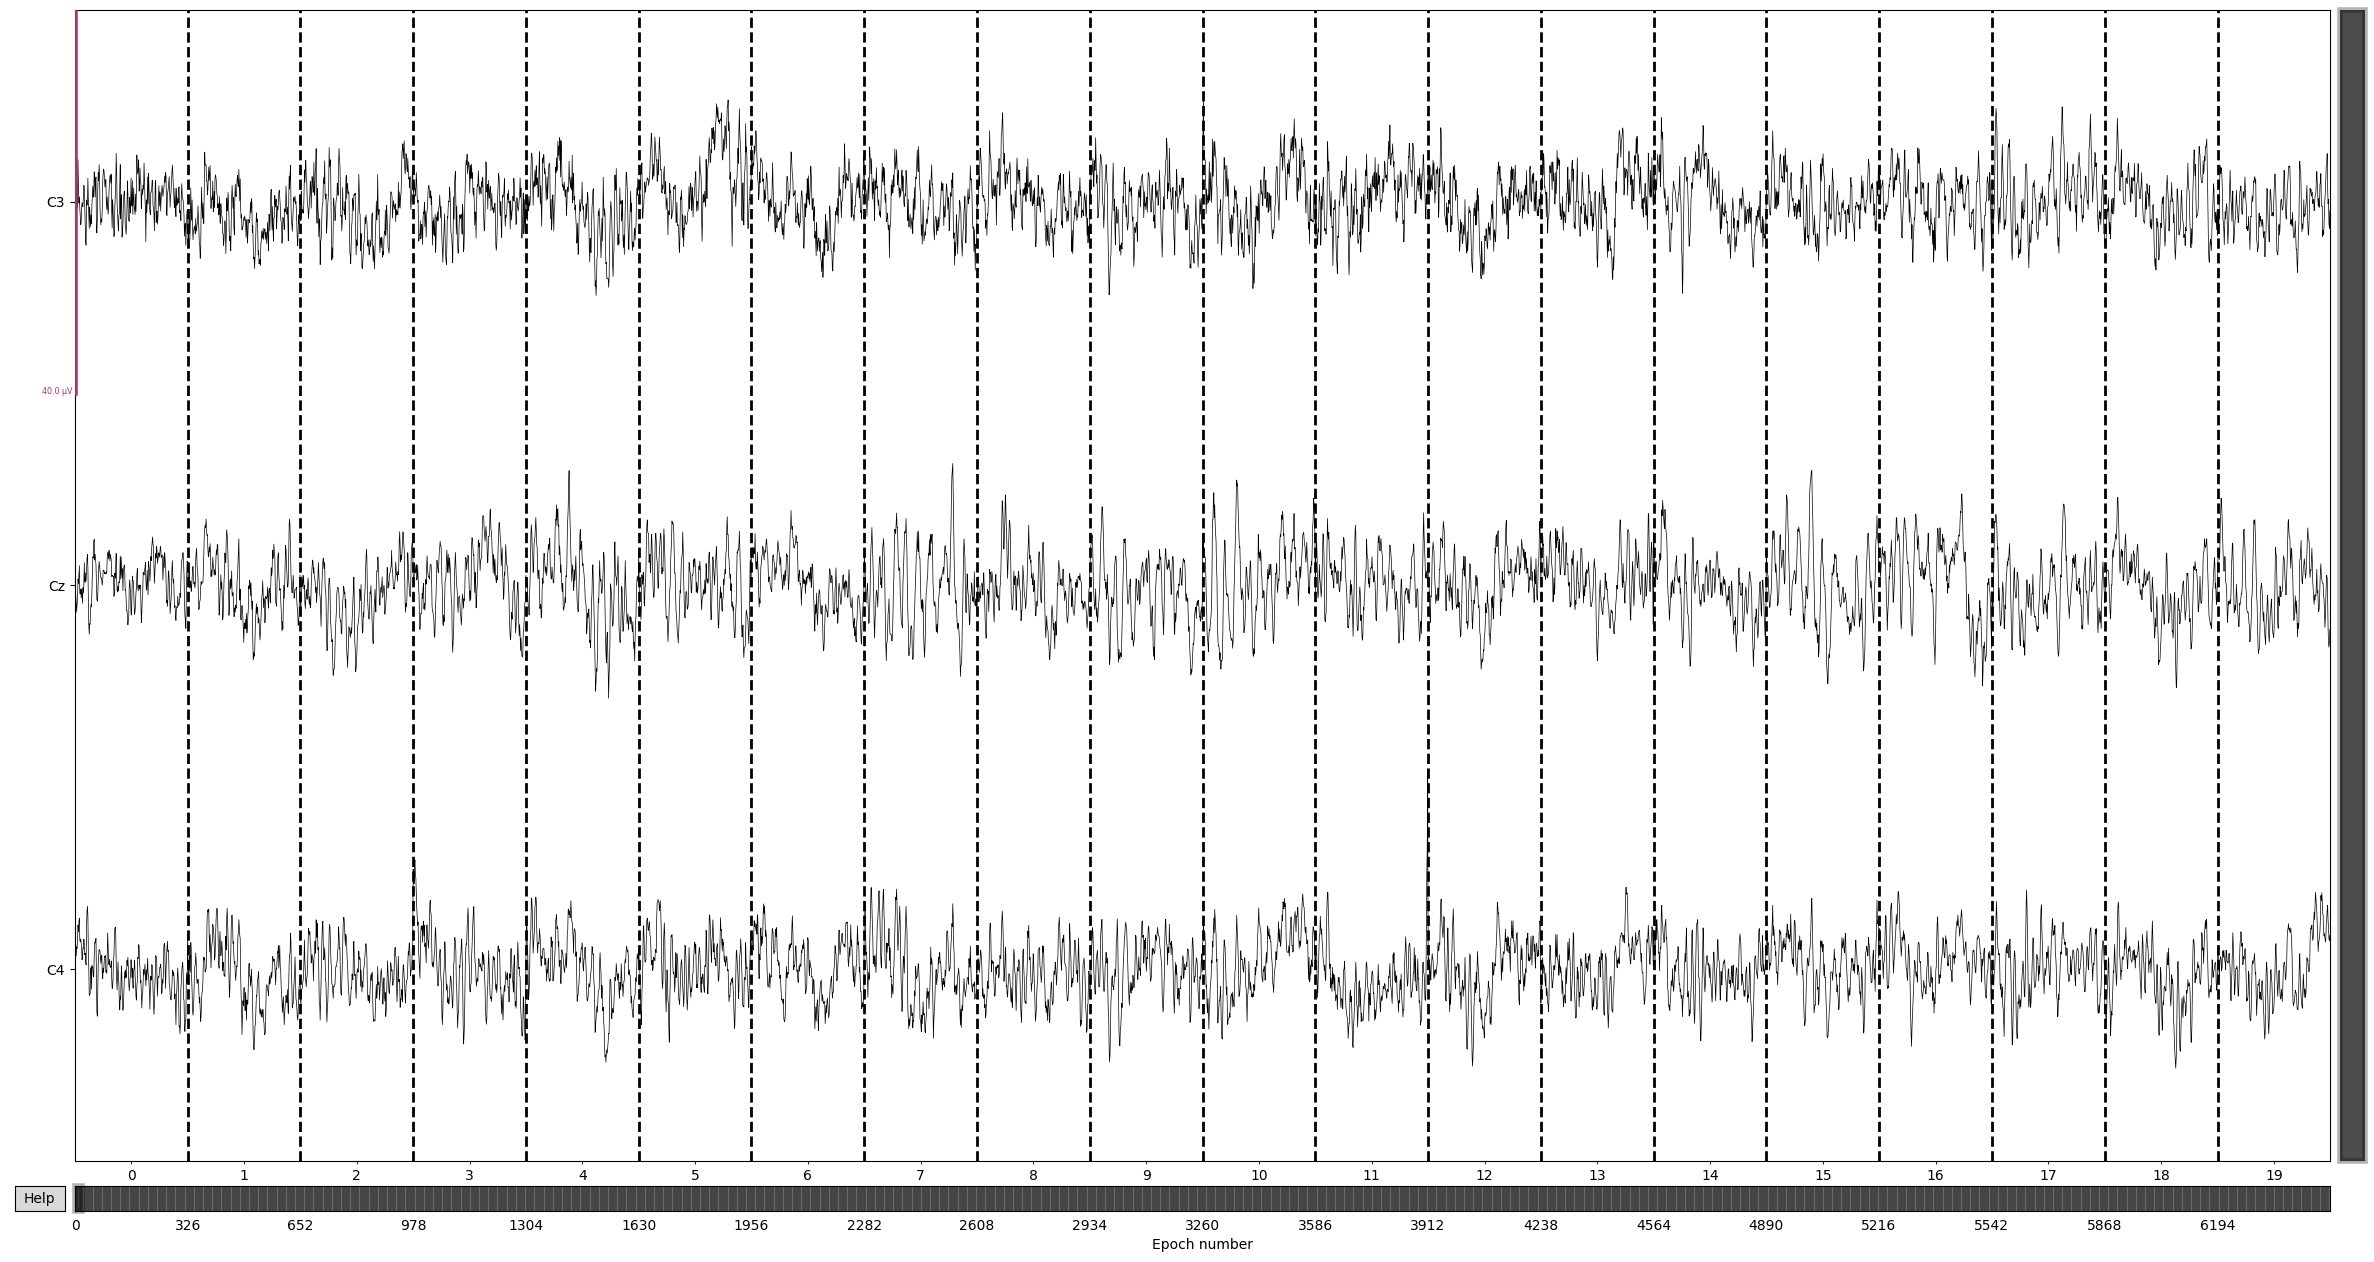

    Using multitaper spectrum estimation with 7 DPSS windows


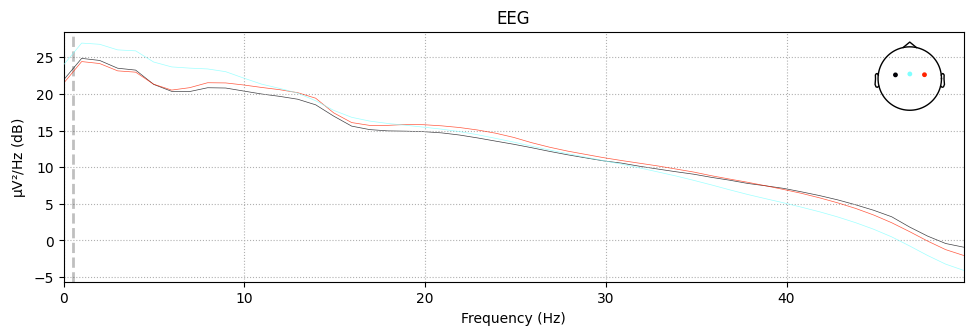

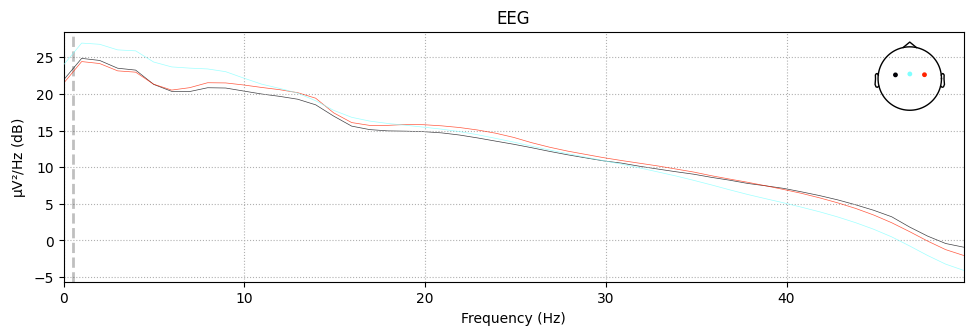

In [4]:
print(epochs1)
epochs1.plot()
epochs1.plot_psd(fmax=50)

In [5]:
import torch   
import torch.optim as optim  
from torch.utils.data import Dataset, DataLoader  
from torch.utils.data import Subset  
from torch import nn  
import torch.nn.functional as F  
from torch.utils.data import RandomSampler  
from torch.utils.data import SequentialSampler  

from common import EpochsDataset  

cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data)
train_idx, test_idx = next(cv_split)


def scale(X):
    """Standard scaling of data along the last dimention.
    Parameters
    ----------
    X : array, shape (n_channels, n_times)
        The input signals.
    Returns
    -------
    X_t : array, shape (n_channels, n_times)
        The scaled signals.
    """
    return X / 2e-5

dataset = EpochsDataset(epochs_data, labels, transform=scale)

ds_train, ds_valid = Subset(dataset, train_idx), Subset(dataset, test_idx)

batch_size_train = len(ds_train)
batch_size_valid = len(ds_valid)
sampler_train = RandomSampler(ds_train)
sampler_valid = SequentialSampler(ds_valid)

# create loaders
num_workers = 0
loader_train = \
    DataLoader(ds_train, batch_size=batch_size_train,
               num_workers=num_workers, sampler=sampler_train)
loader_valid = \
    DataLoader(ds_valid, batch_size=batch_size_valid,
               num_workers=num_workers, sampler=sampler_valid)

In [6]:
class SingleNet(nn.Module):
    def __init__(self):
        super().__init__()

        # define model architecture
        # torch.Size([36, 1, 64, 256])
        # temporal convolutional kernel 25 filter with size(11,1)
        #input [224, 1, 22, 256]
        # new input [96, 1, 3, 151]
        #A block
        
        #Temporal torch.Size([5216, 8, 1, 151])
        self.temporalConv = nn.Conv1d(in_channels=1,out_channels=8,kernel_size=(3,1),stride=1)
        #Spatial torch.Size([5216, 8, 1, 151])
        self.spatialConv = nn.Conv1d(in_channels=8,out_channels=8,kernel_size=(1,1),stride=1)
        #Maxx torch.Size([5216, 41, 1, 2])
        self.maxPooling = nn.MaxPool2d((1,3))
        
        #B block
        # 1st convo output [25,1,371]
        #input [224, 8, 1, 85]
        # new input [96, 8, 1, 50]
        
        self.firstConv = nn.Conv1d(in_channels=8, out_channels=8,kernel_size=(1,1))
        self.secondConv = nn.Conv1d(in_channels=8, out_channels=33,kernel_size=(1,1))
        self.thirdConv = nn.Conv1d(in_channels=33,out_channels=33,kernel_size=(1,1))
        self.maxPooling2 = nn.MaxPool2d((1,3))
        # out Secondblock torch.Size([5216, 41, 1, 16])
        
        #C block
        #input [224, 41, 1, 28]
        #new input [96, 41, 1, 16]
        
        self.classify = nn.Conv1d(in_channels=41,out_channels=41,kernel_size=(1,11)) 
        #Classify torch.Size([5216, 41, 1, 6])
        self.maxPooling3 = nn.MaxPool2d((1,3))
        #Maxx torch.Size([5216, 41, 1, 2])
        self.flatten = nn.Flatten()
        #flatter torch.Size([5216, 82])
        self.elu = nn.ELU()
        #elu torch.Size([5216, 82])
        self.fully = nn.Linear(205,2) 
        #fully torch.Size([5216, 2])
        
        
    def forward(self, x):
        #Conv1d(1,ch,kernel_size=10) on tensor [batch=1, channels=1, time=400]
        
        x = self.temporalConv(x)
        x= self.spatialConv(x)
        x = self.elu(x)
        x = self.maxPooling(x)

        
        out2 = self.firstConv(x)
        out2 = self.secondConv(out2)
        out2 = self.thirdConv(out2)
        out3 = torch.cat((x,out2),1)
        out3 = self.maxPooling2(out3)
        
        
        out3 = self.classify(out3)
        out3 = self.maxPooling3(out3)
        out3 = self.flatten(out3)
        out3 = self.elu(out3)
        out3 = self.fully(out3)
        out3 = self.elu(out3)
        out3 = F.log_softmax(out3, dim=1)
        
        return out3

In [7]:
#device = 'cuda'
device = 'cpu'
model = SingleNet()


In [8]:
# Train
from common import train

lr = 1e-4
n_epochs = 100
patience = 100

model.to(device=device) 
optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

best_model,train_loss,valid_loss = train(model, loader_train, loader_valid, optimizer,criterion,n_epochs, patience, device)


Starting epoch 1 / 100


  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\asus\anaconda3\envs\tf_gpu\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
avg val loss: 0.6939: 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


---  Accuracy : 0.4976993799209595 


best val loss inf -> 0.6939

Starting epoch 2 / 100


avg val loss: 0.6935: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


---  Accuracy : 0.4976993799209595 


best val loss 0.6939 -> 0.6935

Starting epoch 3 / 100


avg val loss: 0.6933: 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]


---  Accuracy : 0.48542943596839905 


best val loss 0.6935 -> 0.6933

Starting epoch 4 / 100


avg val loss: 0.6934: 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


---  Accuracy : 0.5023006200790405 

Waiting += 1

Starting epoch 5 / 100


avg val loss: 0.6935: 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]


---  Accuracy : 0.5023006200790405 

Waiting += 1

Starting epoch 6 / 100


avg val loss: 0.6935: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


---  Accuracy : 0.5023006200790405 

Waiting += 1

Starting epoch 7 / 100


avg val loss: 0.6934: 100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


---  Accuracy : 0.5023006200790405 

Waiting += 1

Starting epoch 8 / 100


avg val loss: 0.6934: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


---  Accuracy : 0.5030674934387207 

Waiting += 1

Starting epoch 9 / 100


avg val loss: 0.6933: 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]


---  Accuracy : 0.5007668733596802 


best val loss 0.6933 -> 0.6933

Starting epoch 10 / 100


avg val loss: 0.6933: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


---  Accuracy : 0.49233129620552063 


best val loss 0.6933 -> 0.6933

Starting epoch 11 / 100


avg val loss: 0.6933: 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]


---  Accuracy : 0.49846625328063965 

Waiting += 1

Starting epoch 12 / 100


avg val loss: 0.6933: 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]


---  Accuracy : 0.4969325065612793 

Waiting += 1

Starting epoch 13 / 100


avg val loss: 0.6934: 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]


---  Accuracy : 0.4976993799209595 

Waiting += 1

Starting epoch 14 / 100


avg val loss: 0.6934: 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]


---  Accuracy : 0.4976993799209595 

Waiting += 1

Starting epoch 15 / 100


avg val loss: 0.6934: 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]


---  Accuracy : 0.4976993799209595 

Waiting += 1

Starting epoch 16 / 100


avg val loss: 0.6934: 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


---  Accuracy : 0.4976993799209595 

Waiting += 1

Starting epoch 17 / 100


avg val loss: 0.6933: 100%|██████████| 1/1 [00:00<00:00,  7.09it/s]


---  Accuracy : 0.4976993799209595 

Waiting += 1

Starting epoch 18 / 100


avg val loss: 0.6933: 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]


---  Accuracy : 0.49846625328063965 

Waiting += 1

Starting epoch 19 / 100


avg val loss: 0.6932: 100%|██████████| 1/1 [00:00<00:00,  6.33it/s]


---  Accuracy : 0.5069018602371216 


best val loss 0.6933 -> 0.6932

Starting epoch 20 / 100


avg val loss: 0.6932: 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]


---  Accuracy : 0.5099693536758423 


best val loss 0.6932 -> 0.6932

Starting epoch 21 / 100


avg val loss: 0.6932: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


---  Accuracy : 0.49233129620552063 


best val loss 0.6932 -> 0.6932

Starting epoch 22 / 100


avg val loss: 0.6931: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


---  Accuracy : 0.4892638027667999 


best val loss 0.6932 -> 0.6931

Starting epoch 23 / 100


avg val loss: 0.6931: 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]


---  Accuracy : 0.4907975494861603 


best val loss 0.6931 -> 0.6931

Starting epoch 24 / 100


avg val loss: 0.6931: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


---  Accuracy : 0.49233129620552063 


best val loss 0.6931 -> 0.6931

Starting epoch 25 / 100


avg val loss: 0.6931: 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]


---  Accuracy : 0.49233129620552063 


best val loss 0.6931 -> 0.6931

Starting epoch 26 / 100


avg val loss: 0.6931: 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


---  Accuracy : 0.48849692940711975 


best val loss 0.6931 -> 0.6931

Starting epoch 27 / 100


avg val loss: 0.6931: 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]


---  Accuracy : 0.4907975494861603 


best val loss 0.6931 -> 0.6931

Starting epoch 28 / 100


avg val loss: 0.6931: 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]


---  Accuracy : 0.4961656332015991 


best val loss 0.6931 -> 0.6931

Starting epoch 29 / 100


avg val loss: 0.6931: 100%|██████████| 1/1 [00:00<00:00,  7.29it/s]


---  Accuracy : 0.5130367875099182 


best val loss 0.6931 -> 0.6931

Starting epoch 30 / 100


avg val loss: 0.6931: 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]


---  Accuracy : 0.52070552110672 

Waiting += 1

Starting epoch 31 / 100


avg val loss: 0.6931: 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


---  Accuracy : 0.5107361674308777 

Waiting += 1

Starting epoch 32 / 100


avg val loss: 0.6931: 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]


---  Accuracy : 0.5115030407905579 

Waiting += 1

Starting epoch 33 / 100


avg val loss: 0.6931: 100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


---  Accuracy : 0.5092024803161621 


best val loss 0.6931 -> 0.6931

Starting epoch 34 / 100


avg val loss: 0.6930: 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]


---  Accuracy : 0.5107361674308777 


best val loss 0.6931 -> 0.6930

Starting epoch 35 / 100


avg val loss: 0.6930: 100%|██████████| 1/1 [00:00<00:00,  6.76it/s]


---  Accuracy : 0.5168711543083191 


best val loss 0.6930 -> 0.6930

Starting epoch 36 / 100


avg val loss: 0.6930: 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]


---  Accuracy : 0.5153374075889587 


best val loss 0.6930 -> 0.6930

Starting epoch 37 / 100


avg val loss: 0.6930: 100%|██████████| 1/1 [00:00<00:00,  6.28it/s]


---  Accuracy : 0.532975435256958 


best val loss 0.6930 -> 0.6930

Starting epoch 38 / 100


avg val loss: 0.6929: 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]


---  Accuracy : 0.5414110422134399 


best val loss 0.6930 -> 0.6929

Starting epoch 39 / 100


avg val loss: 0.6929: 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


---  Accuracy : 0.5184049010276794 


best val loss 0.6929 -> 0.6929

Starting epoch 40 / 100


avg val loss: 0.6929: 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]


---  Accuracy : 0.5069018602371216 


best val loss 0.6929 -> 0.6929

Starting epoch 41 / 100


avg val loss: 0.6929: 100%|██████████| 1/1 [00:00<00:00,  6.17it/s]


---  Accuracy : 0.504601240158081 


best val loss 0.6929 -> 0.6929

Starting epoch 42 / 100


avg val loss: 0.6929: 100%|██████████| 1/1 [00:00<00:00,  7.05it/s]


---  Accuracy : 0.5038343667984009 


best val loss 0.6929 -> 0.6929

Starting epoch 43 / 100


avg val loss: 0.6928: 100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


---  Accuracy : 0.5084356069564819 


best val loss 0.6929 -> 0.6928

Starting epoch 44 / 100


avg val loss: 0.6928: 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]


---  Accuracy : 0.5076687335968018 


best val loss 0.6928 -> 0.6928

Starting epoch 45 / 100


avg val loss: 0.6928: 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


---  Accuracy : 0.5237730145454407 


best val loss 0.6928 -> 0.6928

Starting epoch 46 / 100


avg val loss: 0.6928: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


---  Accuracy : 0.5575153231620789 


best val loss 0.6928 -> 0.6928

Starting epoch 47 / 100


avg val loss: 0.6928: 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


---  Accuracy : 0.5490797758102417 


best val loss 0.6928 -> 0.6928

Starting epoch 48 / 100


avg val loss: 0.6928: 100%|██████████| 1/1 [00:00<00:00,  6.45it/s]


---  Accuracy : 0.5375766754150391 


best val loss 0.6928 -> 0.6928

Starting epoch 49 / 100


avg val loss: 0.6928: 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]


---  Accuracy : 0.5391104221343994 


best val loss 0.6928 -> 0.6928

Starting epoch 50 / 100


avg val loss: 0.6928: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]


---  Accuracy : 0.5414110422134399 


best val loss 0.6928 -> 0.6928

Starting epoch 51 / 100


avg val loss: 0.6927: 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]


---  Accuracy : 0.5444785356521606 


best val loss 0.6928 -> 0.6927

Starting epoch 52 / 100


avg val loss: 0.6927: 100%|██████████| 1/1 [00:00<00:00,  6.83it/s]


---  Accuracy : 0.5552147030830383 


best val loss 0.6927 -> 0.6927

Starting epoch 53 / 100


avg val loss: 0.6927: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


---  Accuracy : 0.558282196521759 


best val loss 0.6927 -> 0.6927

Starting epoch 54 / 100


avg val loss: 0.6927: 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]


---  Accuracy : 0.5467791557312012 


best val loss 0.6927 -> 0.6927

Starting epoch 55 / 100


avg val loss: 0.6926: 100%|██████████| 1/1 [00:00<00:00,  6.45it/s]


---  Accuracy : 0.5337423086166382 


best val loss 0.6927 -> 0.6926

Starting epoch 56 / 100


avg val loss: 0.6926: 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]


---  Accuracy : 0.5314416885375977 


best val loss 0.6926 -> 0.6926

Starting epoch 57 / 100


avg val loss: 0.6926: 100%|██████████| 1/1 [00:00<00:00,  6.82it/s]


---  Accuracy : 0.5383435487747192 


best val loss 0.6926 -> 0.6926

Starting epoch 58 / 100


avg val loss: 0.6926: 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]


---  Accuracy : 0.5291411280632019 


best val loss 0.6926 -> 0.6926

Starting epoch 59 / 100


avg val loss: 0.6926: 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]


---  Accuracy : 0.5391104221343994 


best val loss 0.6926 -> 0.6926

Starting epoch 60 / 100


avg val loss: 0.6925: 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


---  Accuracy : 0.5475460290908813 


best val loss 0.6926 -> 0.6925

Starting epoch 61 / 100


avg val loss: 0.6925: 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]


---  Accuracy : 0.5521472096443176 


best val loss 0.6925 -> 0.6925

Starting epoch 62 / 100


avg val loss: 0.6925: 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


---  Accuracy : 0.5552147030830383 


best val loss 0.6925 -> 0.6925

Starting epoch 63 / 100


avg val loss: 0.6925: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


---  Accuracy : 0.5567484498023987 


best val loss 0.6925 -> 0.6925

Starting epoch 64 / 100


avg val loss: 0.6925: 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]


---  Accuracy : 0.5590490698814392 


best val loss 0.6925 -> 0.6925

Starting epoch 65 / 100


avg val loss: 0.6924: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


---  Accuracy : 0.5567484498023987 


best val loss 0.6925 -> 0.6924

Starting epoch 66 / 100


avg val loss: 0.6924: 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]


---  Accuracy : 0.5575153231620789 


best val loss 0.6924 -> 0.6924

Starting epoch 67 / 100


avg val loss: 0.6924: 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


---  Accuracy : 0.5559815764427185 


best val loss 0.6924 -> 0.6924

Starting epoch 68 / 100


avg val loss: 0.6923: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


---  Accuracy : 0.5490797758102417 


best val loss 0.6924 -> 0.6923

Starting epoch 69 / 100


avg val loss: 0.6923: 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


---  Accuracy : 0.5483129024505615 


best val loss 0.6923 -> 0.6923

Starting epoch 70 / 100


avg val loss: 0.6923: 100%|██████████| 1/1 [00:00<00:00,  6.76it/s]


---  Accuracy : 0.5498466491699219 


best val loss 0.6923 -> 0.6923

Starting epoch 71 / 100


avg val loss: 0.6923: 100%|██████████| 1/1 [00:00<00:00,  6.33it/s]


---  Accuracy : 0.5544478297233582 


best val loss 0.6923 -> 0.6923

Starting epoch 72 / 100


avg val loss: 0.6922: 100%|██████████| 1/1 [00:00<00:00,  7.07it/s]


---  Accuracy : 0.5498466491699219 


best val loss 0.6923 -> 0.6922

Starting epoch 73 / 100


avg val loss: 0.6922: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


---  Accuracy : 0.5552147030830383 


best val loss 0.6922 -> 0.6922

Starting epoch 74 / 100


avg val loss: 0.6922: 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


---  Accuracy : 0.5644171833992004 


best val loss 0.6922 -> 0.6922

Starting epoch 75 / 100


avg val loss: 0.6921: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


---  Accuracy : 0.5621165633201599 


best val loss 0.6922 -> 0.6921

Starting epoch 76 / 100


avg val loss: 0.6921: 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


---  Accuracy : 0.5621165633201599 


best val loss 0.6921 -> 0.6921

Starting epoch 77 / 100


avg val loss: 0.6921: 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]


---  Accuracy : 0.5628834366798401 


best val loss 0.6921 -> 0.6921

Starting epoch 78 / 100


avg val loss: 0.6921: 100%|██████████| 1/1 [00:00<00:00,  8.10it/s]


---  Accuracy : 0.5613496899604797 


best val loss 0.6921 -> 0.6921

Starting epoch 79 / 100


avg val loss: 0.6920: 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


---  Accuracy : 0.5575153231620789 


best val loss 0.6921 -> 0.6920

Starting epoch 80 / 100


avg val loss: 0.6920: 100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


---  Accuracy : 0.5559815764427185 


best val loss 0.6920 -> 0.6920

Starting epoch 81 / 100


avg val loss: 0.6920: 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


---  Accuracy : 0.5567484498023987 


best val loss 0.6920 -> 0.6920

Starting epoch 82 / 100


avg val loss: 0.6919: 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]


---  Accuracy : 0.5613496899604797 


best val loss 0.6920 -> 0.6919

Starting epoch 83 / 100


avg val loss: 0.6919: 100%|██████████| 1/1 [00:00<00:00,  7.11it/s]


---  Accuracy : 0.5590490698814392 


best val loss 0.6919 -> 0.6919

Starting epoch 84 / 100


avg val loss: 0.6918: 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]


---  Accuracy : 0.5605828166007996 


best val loss 0.6919 -> 0.6918

Starting epoch 85 / 100


avg val loss: 0.6918: 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]


---  Accuracy : 0.5621165633201599 


best val loss 0.6918 -> 0.6918

Starting epoch 86 / 100


avg val loss: 0.6918: 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


---  Accuracy : 0.5659509301185608 


best val loss 0.6918 -> 0.6918

Starting epoch 87 / 100


avg val loss: 0.6917: 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]


---  Accuracy : 0.566717803478241 


best val loss 0.6918 -> 0.6917

Starting epoch 88 / 100


avg val loss: 0.6917: 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]


---  Accuracy : 0.5682515501976013 


best val loss 0.6917 -> 0.6917

Starting epoch 89 / 100


avg val loss: 0.6917: 100%|██████████| 1/1 [00:00<00:00,  7.05it/s]


---  Accuracy : 0.5674846768379211 


best val loss 0.6917 -> 0.6917

Starting epoch 90 / 100


avg val loss: 0.6916: 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


---  Accuracy : 0.5674846768379211 


best val loss 0.6917 -> 0.6916

Starting epoch 91 / 100


avg val loss: 0.6916: 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]


---  Accuracy : 0.5682515501976013 


best val loss 0.6916 -> 0.6916

Starting epoch 92 / 100


avg val loss: 0.6915: 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


---  Accuracy : 0.5690184235572815 


best val loss 0.6916 -> 0.6915

Starting epoch 93 / 100


avg val loss: 0.6915: 100%|██████████| 1/1 [00:00<00:00,  6.20it/s]


---  Accuracy : 0.5705521702766418 


best val loss 0.6915 -> 0.6915

Starting epoch 94 / 100


avg val loss: 0.6914: 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]


---  Accuracy : 0.5674846768379211 


best val loss 0.6915 -> 0.6914

Starting epoch 95 / 100


avg val loss: 0.6914: 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]


---  Accuracy : 0.5682515501976013 


best val loss 0.6914 -> 0.6914

Starting epoch 96 / 100


avg val loss: 0.6913: 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]


---  Accuracy : 0.5705521702766418 


best val loss 0.6914 -> 0.6913

Starting epoch 97 / 100


avg val loss: 0.6913: 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


---  Accuracy : 0.5705521702766418 


best val loss 0.6913 -> 0.6913

Starting epoch 98 / 100


avg val loss: 0.6912: 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]


---  Accuracy : 0.5697852969169617 


best val loss 0.6913 -> 0.6912

Starting epoch 99 / 100


avg val loss: 0.6912: 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]


---  Accuracy : 0.571319043636322 


best val loss 0.6912 -> 0.6912

Starting epoch 100 / 100


avg val loss: 0.6911: 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]

---  Accuracy : 0.571319043636322 


best val loss 0.6912 -> 0.6911


In [9]:
"""# Test model works:

n_samples_test = 10
y_test = torch.randint(0, 2, (n_samples_test,))
print(y_test.shape) 
y_pred = model.forward(torch.randn(n_samples_test, 1, *epochs_data.shape[1:]))
output = F.cross_entropy(y_pred, y_test)
_, top_class = y_pred.topk(1, dim=1)
print(top_class)
"""

'# Test model works:\n\nn_samples_test = 10\ny_test = torch.randint(0, 2, (n_samples_test,))\nprint(y_test.shape) \ny_pred = model.forward(torch.randn(n_samples_test, 1, *epochs_data.shape[1:]))\noutput = F.cross_entropy(y_pred, y_test)\n_, top_class = y_pred.topk(1, dim=1)\nprint(top_class)\n'

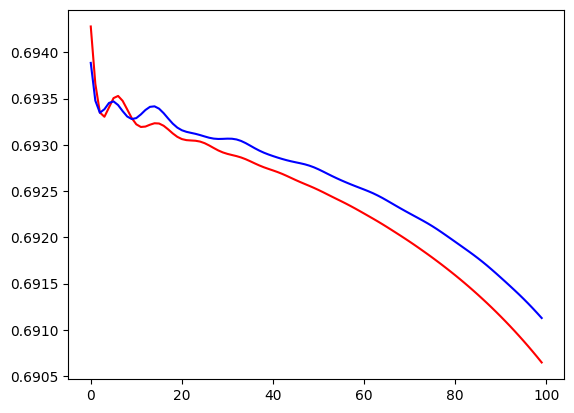

In [12]:
import matplotlib.pyplot as plt
plt.plot(train_loss,'r')
plt.plot(valid_loss,'b')
plt.show()


In [11]:
print(train_loss)


[0.6942798495292664, 0.6936606168746948, 0.6933494806289673, 0.6933034062385559, 0.6934040784835815, 0.6935052871704102, 0.6935286521911621, 0.6934755444526672, 0.693382740020752, 0.6932889223098755, 0.6932217478752136, 0.6931931376457214, 0.69319748878479, 0.6932175755500793, 0.6932333111763, 0.6932305693626404, 0.693206250667572, 0.6931668519973755, 0.693123459815979, 0.693086564540863, 0.6930622458457947, 0.6930508017539978, 0.6930471062660217, 0.6930440664291382, 0.6930353045463562, 0.6930178999900818, 0.6929932832717896, 0.6929656267166138, 0.6929392218589783, 0.6929178833961487, 0.692902147769928, 0.6928898096084595, 0.6928779482841492, 0.6928633451461792, 0.6928446888923645, 0.6928226947784424, 0.6927995085716248, 0.6927772760391235, 0.6927574276924133, 0.6927400231361389, 0.692723274230957, 0.6927058100700378, 0.6926863789558411, 0.692664623260498, 0.6926418542861938, 0.6926190257072449, 0.6925972104072571, 0.6925763487815857, 0.6925557851791382, 0.6925344467163086, 0.692511737